In [0]:
! pip install gym[box2d]
! pip install Keras==2.1.5
! pip install Keras-Applications==1.0.8
! pip install Keras-Preprocessing==1.1.0
! pip install keras-rl==0.4.2
! pip install tensorboard==2.0.1
! pip install tensorflow==1.5.0
! pip install tensorflow-estimator==2.0.1
! pip install tensorflow-tensorboard==1.5.1
! pip install wandb

     |████████████████████████████████| 450kB 3.5MB/s 
     |████████████████████████████████| 337kB 3.4MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5
     |████████████████████████████████| 40kB 2.6MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp36-none-any.whl size=48379 sha256=c50f6149ece598404c3dc044fd3824d32755edbd215f01cb88f7b9f54b13fad2
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl
     |████████████████████████████████| 3.8MB 3.4MB/s 
     |████████████████████████████████| 2.4MB 29.9MB/s 
     |████████████████████████████████| 81kB 7.4MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.8.1 which is incompatible.
  Found existing in

     |████████████████████████████████| 44.4MB 37.8MB/s 
     |████████████████████████████████| 3.0MB 21.2MB/s 
     |████████████████████████████████| 890kB 22.1MB/s 
  Created wheel for html5lib: filename=html5lib-0.9999999-cp36-none-any.whl size=107221 sha256=b4020637a86e8c869643ca8f9a1fc031bcdcf2c2a9e260bb82aada54d2579991
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
ERROR: magenta 0.3.19 has requirement tensorflow>=1.12.0, but you'll have tensorflow 1.5.0 which is incompatible.
  Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Found existing installation: bleach 3.1.0
    Uninstalling bleach-3.1.0:
      Successfully uninstalled bleach-3.1.0
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 450k

In [0]:
# Import gym module.
import gym
import argparse
import numpy as np
import tensorflow as tf


from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam,SGD

from rl.agents.sarsa import SARSAAgent
from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent


from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [0]:
steps=1000

In [0]:
env_name = "LunarLander-v2"
env = gym.make(env_name)

In [0]:
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n  # get number of actions in Lunar Lander

Define Network and Policy

In [0]:
def get_model():
  model = Sequential()
  model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
  model.add(Dense(64))
  model.add(Activation('relu'))
  model.add(Dense(64))
  model.add(Activation('relu'))
  # Need another layer for predicted network. Also need to perform Experience replay.
  model.add(Dense(nb_actions))
  model.add(Activation('linear'))
  return model


In [0]:
policy = EpsGreedyQPolicy()
memory = SequentialMemory(limit=50000, window_length=1)


Selecting Agent

In [0]:
agent=DQNAgent(model=get_model(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=1000, policy=policy,target_model_update=4)
weight_name="DQN_AGENT"

In [0]:
agent = SARSAAgent(model=get_model(), nb_actions=nb_actions, nb_steps_warmup=1000, policy=policy)
weight_name="SARSA_AGENT"

In [0]:
agent = DDPGAgent(nb_actions=nb_actions,actor=model,critic=model,memory=memory,train_interval=4,nb_steps_warmup_actor=1000,nb_steps_warmup_critic=100,critic_action_input=4)

Compile Agent


In [0]:
agent.compile(Adam(lr=1e-5), metrics=['mae'])

Custom CallBack Fucntion

In [0]:
class CustomCallBack(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_logs=[]
  def on_epoch_end(self, batch, logs=None):
    self.batch_logs.append((batch,logs))
  def getBatchLogs(self):
    return self.batch_logs

Fitting the Model

In [0]:
# Training Code with WandB
ccb = CustomCallBack()
agent.fit(env, nb_steps=steps*100, visualize=False, verbose=1,nb_max_episode_steps=steps, callbacks=[ccb],action_repetition=2)
agent.save_weights(weight_name+".weights",overwrite=True)

Training for 100000 steps ...
Interval 1 (0 steps performed)
10000/10000 [==============================] - 57s 6ms/step - reward: -10.8842
256 episodes - episode_reward: -425.070 [-1576.293, -22.506] - loss: 80.771 - mean_absolute_error: 1.924 - mean_q: -0.353

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: -6.7291
277 episodes - episode_reward: -242.778 [-579.085, 6.293] - loss: 97.554 - mean_absolute_error: 6.626 - mean_q: -6.029

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: -5.8454
267 episodes - episode_reward: -219.515 [-516.268, 35.393] - loss: 78.987 - mean_absolute_error: 26.154 - mean_q: -31.542

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: -9.9943
214 episodes - episode_reward: -466.309 [-668.043, 44.982] - loss: 58.207 - mean_absolute_error: 60.201 - mean_q: -76.721

Interval 5 (40000 steps performe

In [0]:
batch_logs= ccb.getBatchLogs()

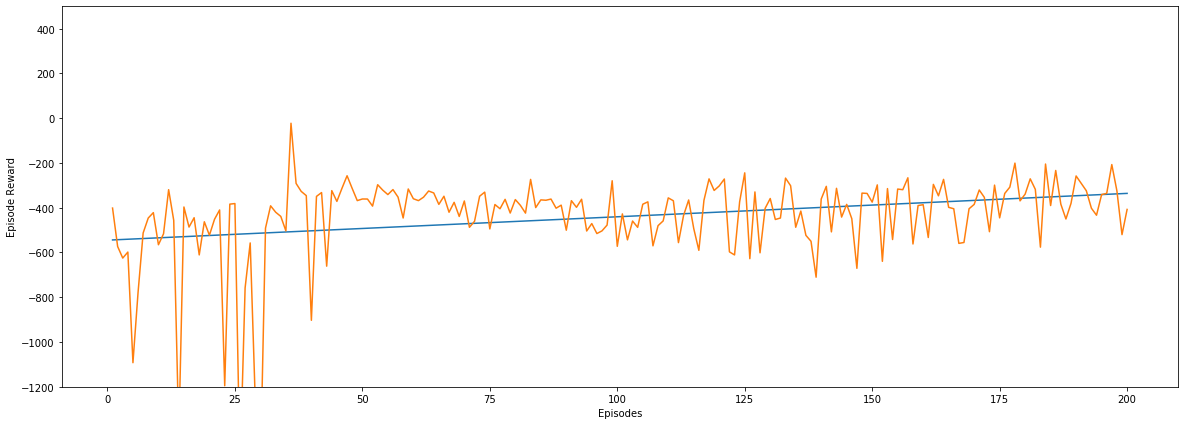

In [0]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,7)
x=[ep[0]+1 for ep in batch_logs]
y=[ep[1]['episode_reward'] for ep in batch_logs]
plt.ylim(-1200,500)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.plot(x,y)
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.show()

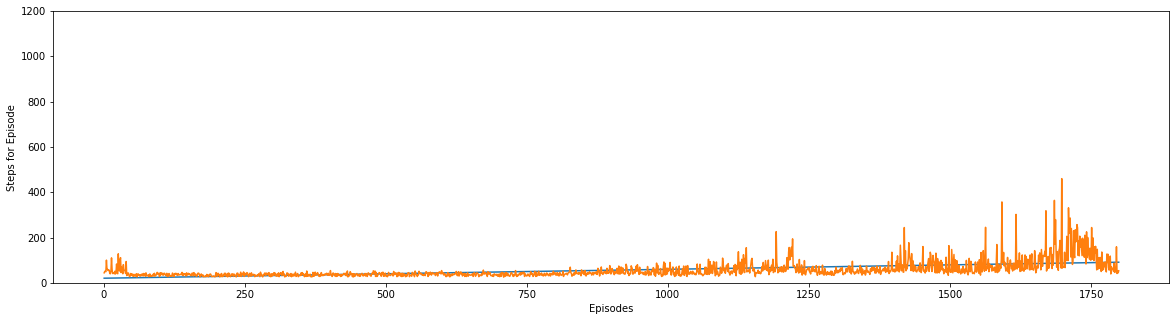

In [0]:
plt.rcParams["figure.figsize"] = (20,5)
x=[ep[0]+1 for ep in batch_logs]
y=[ep[1]['nb_episode_steps'] for ep in batch_logs]
plt.ylim(0,1200)
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)))
plt.plot(x,y)
plt.xlabel('Episodes')
plt.ylabel('Steps for Episode')
plt.show()

In [0]:
cb = CustomCallBack()
agent.load_weights(weight_name+".weights")
agent.test(env,nb_episodes=10,visualize=False,nb_max_episode_steps=1000,verbose=1,callbacks=[cb])


Testing for 10 episodes ...
Episode 1: reward: -234.418, steps: 141
Episode 2: reward: -213.967, steps: 109
Episode 3: reward: -211.239, steps: 113
Episode 4: reward: -199.336, steps: 114
Episode 5: reward: -163.898, steps: 113
Episode 6: reward: -83.214, steps: 253
Episode 7: reward: -196.012, steps: 95
Episode 8: reward: -229.700, steps: 99
Episode 9: reward: -225.691, steps: 246
Episode 10: reward: -231.627, steps: 130


In [0]:
from statistics import mean
mean([l[1]['episode_reward'] for l in cb.getBatchLogs()])

-198.91027193063735